In [2]:
import pandas as pd
import numpy as np

#导入pyplot模块
import matplotlib.pyplot as plt

#使用中文字体
from pylab import mpl
mpl.rcParams['font.sans-serif']="Simsun"
mpl.rcParams['axes.unicode_minus']=False

#使用svg格式，避免图形模糊
%matplotlib inline
%config InlineBackend.figure_format="svg"

#设置缺省颜色和线型
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = (
    cycler(color=['steelblue', 'lightcoral', 'forestgreen', 'darkorange']) 
    + cycler(linestyle=['-', '--', '-.', ':']))

# 时间型数据简介

在来自现实业务系统的数据中，通常会包含时间信息。例如，股票交易数据中的交易日期；淘宝用户购买记录中的下单时间，付款时间，发货时间，收货时间等。

pandas中有四种与时间/日期相关的概念：
 * **日期时间**。指某个时间点。即常见的“某年某月某日 几点几分几秒”
 * **时间段**。如2009年10月（从1号到31号整一个月），2012年3月5日（从0点到24点一整天）等
 * **时间差**。两个时间点之间的绝对差值。如1个小时
 * **日期差**。两个时间点之间的差，与所用的日历有关。例如，农历的1月和公历的1月不一样。
 
一般数据分析中常用的是日期时间。

## 创建时间型索引

使用**date_range**函数可以创建一个连续的时间索引：
 * **periods**参数指定序列的长度
 * **freq**参数指定序列的间隔。
 
常见的freq参数有：
 * **'S'**,秒
 * **'min'**,分
 * **'H'**,小时
 * **'D'**,天
 * **'W'**,周
 * **'M'**,月(末)
 * **'Y'**,年(末)
 * **'MS'**,月(初)
 * **'YS'**,年(初)
 
可以在前面加数字，如**'2D'**表示两天

In [3]:
s=pd.date_range('2002-01',periods=5,freq="2M")
s

DatetimeIndex(['2002-01-31', '2002-03-31', '2002-05-31', '2002-07-31',
               '2002-09-30'],
              dtype='datetime64[ns]', freq='2M')

## 转换时间型序列

使用**to_datetime**可以将字符串/python日期类型序列转换为时间型索引。

In [4]:
s=pd.to_datetime(['2001-01','2003-04'])
s

DatetimeIndex(['2001-01-01', '2003-04-01'], dtype='datetime64[ns]', freq=None)

# 日期型序列运算

## 计算日/月/年/时间

对于时间型索引（注意不是Series），可以通过**day**/**dayofweek**/**month**/**year**/**hour**/**minute**/**second**等属性获取各元素的相应时间信息。

In [5]:
s.year

Index([2001, 2003], dtype='int32')

In [6]:
s1=pd.date_range('2002-01',periods=5,freq="2M")
print(s1)
s2=pd.date_range('2003-01',periods=5,freq="1W")
print(s2)
s1-s2

DatetimeIndex(['2002-01-31', '2002-03-31', '2002-05-31', '2002-07-31',
               '2002-09-30'],
              dtype='datetime64[ns]', freq='2M')
DatetimeIndex(['2003-01-05', '2003-01-12', '2003-01-19', '2003-01-26',
               '2003-02-02'],
              dtype='datetime64[ns]', freq='W-SUN')


TimedeltaIndex(['-339 days', '-287 days', '-233 days', '-179 days',
                '-125 days'],
               dtype='timedelta64[ns]', freq=None)

# 重采样（日期分段）汇总

类似于使用**groupby**进行分类汇总，对索引列为日期型索引的DataFrame可以进行日期分段汇总计算，称为重采样(**resample**)。

注：resample可以在groupby的基础上进行。

In [7]:
df=pd.read_csv("../bank_stock.csv", encoding="GBK", index_col="日期")

#将日期列转换为日期型索引
df.index=pd.to_datetime(df.index)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1248 entries, 2019-02-15 to 2014-01-02
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   股票代码    1248 non-null   object 
 1   名称      1248 non-null   object 
 2   收盘价     1248 non-null   float64
 3   最高价     1248 non-null   float64
 4   最低价     1248 non-null   float64
 5   开盘价     1248 non-null   float64
 6   前收盘     1248 non-null   float64
 7   涨跌额     1248 non-null   float64
 8   涨跌幅     1248 non-null   float64
 9   换手率     1248 non-null   float64
 10  成交量     1248 non-null   int64  
 11  成交金额    1248 non-null   float64
 12  总市值     1248 non-null   float64
 13  流通市值    1248 non-null   float64
dtypes: float64(11), int64(1), object(2)
memory usage: 146.2+ KB


In [8]:
df[["成交金额","成交量"]].resample("M").mean().style.format(precision=3)

,成交金额,成交量
日期,,
2014-01-31 00:00:00,682799465.238,73890053.238
2014-02-28 00:00:00,1091246393.250,117088165.562
2014-03-31 00:00:00,1669843582.286,178425164.333
2014-04-30 00:00:00,1582819118.524,159320438.571
2014-05-31 00:00:00,760179900.150,78295881.900
2014-06-30 00:00:00,652402628.400,68477014.000
2014-07-31 00:00:00,877890946.652,93953277.609
2014-08-31 00:00:00,992860753.762,102828903.762
2014-09-30 00:00:00,1278234270.667,132007317.286


# 滑动窗口（滚动）计算

通过的**rolling**方法可以创建滑动窗口对象，使用滑动窗口对象可以对数据按照滑动窗口的方式进行汇总计算：
 * window参数指定滑动窗口大小
 * 在计算前通常应先对数据**排序**。

滑动窗口的一个常见用途是对波动较大的时间序列，用滑动窗口平均的方式进行平滑。

In [9]:
# 取2018-01-01之后浦发银行的股票数据，按照时间从小到大的顺序排序

df = pd.read_csv("../bank_stock.csv", index_col="日期", encoding="GBK")
# 将日期（索引列）转换为日期型
df.index = pd.to_datetime(df.index)

# 筛选数据
df=df[df.index>='2018-01-01']

#排序
df=df.sort_index()
df.head()

,股票代码,名称,收盘价,最高价,最低价,开盘价,前收盘,涨跌额,涨跌幅,换手率,成交量,成交金额,总市值,流通市值
日期,,,,,,,,,,,,,,
2018-01-02,'600000,浦发银行,12.72,12.77,12.60,12.61,12.59,0.13,1.0326,0.1115,31323053,398614966.0,3.733585e+11,3.574799e+11
2018-01-03,'600000,浦发银行,12.66,12.80,12.66,12.73,12.72,-0.06,-0.4717,0.1346,37839101,480954809.0,3.715973e+11,3.557937e+11
2018-01-04,'600000,浦发银行,12.66,12.73,12.62,12.70,12.66,0.00,0.0000,0.0992,27883804,353205838.0,3.715973e+11,3.557937e+11
2018-01-05,'600000,浦发银行,12.69,12.71,12.62,12.67,12.66,0.03,0.2370,0.1104,31026744,393058250.0,3.724779e+11,3.566368e+11
2018-01-08,'600000,浦发银行,12.68,12.71,12.63,12.69,12.69,-0.01,-0.0788,0.1117,31389887,397842209.0,3.721844e+11,3.563557e+11


In [10]:
# 计算15天的滑动平均
rollingmean=df[["收盘价","开盘价"]].rolling(window="15D").mean()
rollingmean

,收盘价,开盘价
日期,,
2018-01-02,12.720000,12.610000
2018-01-03,12.690000,12.670000
2018-01-04,12.680000,12.680000
2018-01-05,12.682500,12.677500
2018-01-08,12.682000,12.680000
...,...,...
2019-02-11,10.616667,10.590000
2019-02-12,10.666667,10.620000
2019-02-13,10.713333,10.678333


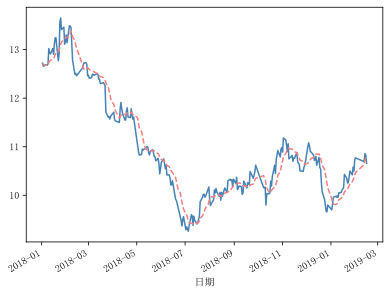

In [11]:
# 绘制收盘价时间趋势图
df["收盘价"].plot()
rollingmean["收盘价"].plot()
plt.show()

# 差分计算
Series/DataFrame的**diff**可以计算差分。因为计算过程中会产生NaN，一般需要和**dropna**方法连用。

In [15]:
df["收盘价"].diff(periods=1).dropna()

日期
2018-01-03   -0.06
2018-01-04    0.00
2018-01-05    0.03
2018-01-08   -0.01
2018-01-09    0.02
              ... 
2019-02-11   -0.07
2019-02-12    0.02
2019-02-13    0.14
2019-02-14   -0.04
2019-02-15   -0.16
Name: 收盘价, Length: 270, dtype: float64